# Lambda vs Fargate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Assumptions

 * Using Ireland region (eu-west-1)

## References

 * Farget cost https://aws.amazon.com/fargate/pricing/
 * Lambda cost https://aws.amazon.com/lambda/pricing/
 * Lambda vCPU per memory https://docs.aws.amazon.com/lambda/latest/dg/configuration-memory.html#configuration-memory-console

In [4]:
FARGET_PER_CPU_PER_HOUR=0.04048
FARGET_PER_GB_PER_HOUR=0.004445
LAMBDA_PER_1M_REQUESTS=0.20
LAMBDA_PER_REQUESTS=LAMBDA_PER_1M_REQUESTS/1e6
LAMBDA_PER_GB_SECOND=0.0000166667
LAMBDA_PER_GB_HOUR=LAMBDA_PER_GB_SECOND*3600
LAMBDA_VCPU_PER_GB=1.769

LABDA_PROV_IDLE_GB_SECOND=0.000004646
LABDA_PROV_IDLE_GB_HOUR=LABDA_PROV_IDLE_GB_SECOND*3600
LAMBDA_PROV_GB_SECOND=0.0000108407
LAMBDA_PROV_GB_HOUR=LAMBDA_PROV_GB_SECOND*3600

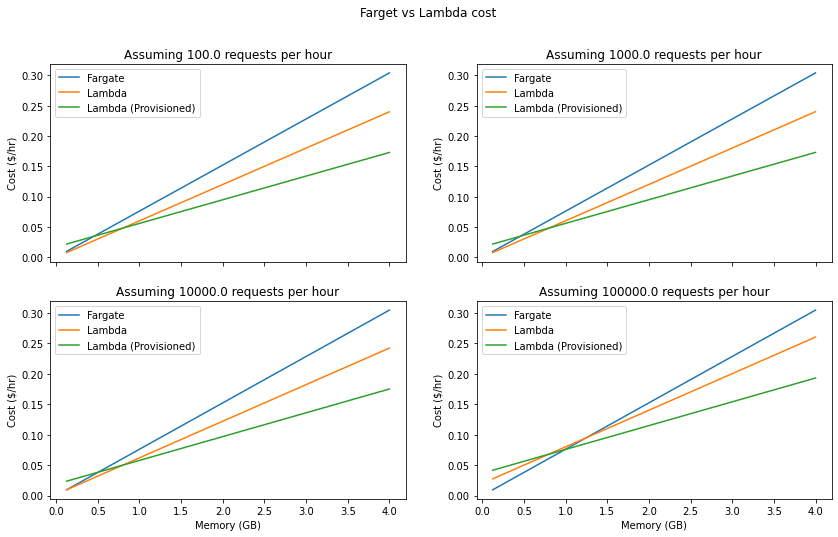

In [55]:
def get_memory_vs_cost(n_req):
    mem_gb = np.linspace(0.125, 4.)
    # To be equivalent to lamdba where CPU is a function of memory
    fargate_vcpu_cost=FARGET_PER_CPU_PER_HOUR * LAMBDA_VCPU_PER_GB * mem_gb
    return pd.DataFrame({
        'mem_gb': mem_gb,
        'fargate': FARGET_PER_GB_PER_HOUR * mem_gb + fargate_vcpu_cost,
        'lambda': LAMBDA_PER_GB_HOUR * mem_gb + LAMBDA_PER_REQUESTS * n_req,
        'lambda_prov': LABDA_PROV_IDLE_GB_HOUR + LAMBDA_PROV_GB_HOUR * mem_gb + LAMBDA_PER_REQUESTS * n_req
    })

fig, axis = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 8)
fig.suptitle('Farget vs Lambda cost')
for n_req, ax in zip(np.power(10, np.linspace(2, 5, 4)), itertools.chain(*axis)):
    df = get_memory_vs_cost(n_req)
    ax.set_title(f'Assuming {n_req} requests per hour')
    sns.lineplot(data=df, x='mem_gb', y='fargate', label='Fargate', ax=ax)
    sns.lineplot(data=df, x='mem_gb', y='lambda', label='Lambda', ax=ax)
    sns.lineplot(data=df, x='mem_gb', y='lambda_prov', label='Lambda (Provisioned)', ax=ax)
    ax.set(xlabel='Memory (GB)', ylabel='Cost ($/hr)')


array([0.5, 1. , 1.5, 2. ])

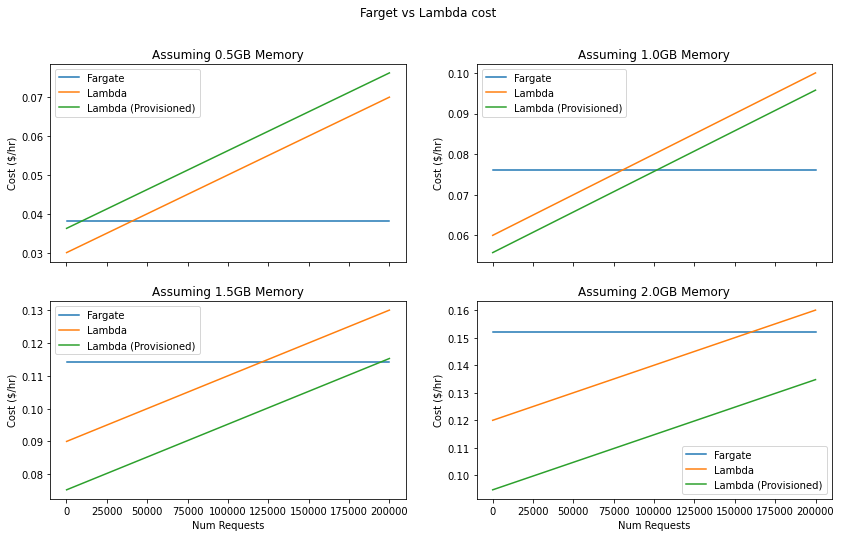

In [64]:
def get_req_vs_cost(mem_gb):
    n_req = np.linspace(100, 2*1e5)
    # To be equivalent to lamdba where CPU is a function of memory
    fargate_vcpu_cost=FARGET_PER_CPU_PER_HOUR * LAMBDA_VCPU_PER_GB * mem_gb
    return pd.DataFrame({
        'n_req': n_req,
        'fargate': FARGET_PER_GB_PER_HOUR * mem_gb + fargate_vcpu_cost + n_req * 0,
        'lambda': LAMBDA_PER_GB_HOUR * mem_gb + LAMBDA_PER_REQUESTS * n_req,
        'lambda_prov': LABDA_PROV_IDLE_GB_HOUR + LAMBDA_PROV_GB_HOUR * mem_gb + LAMBDA_PER_REQUESTS * n_req
    })



fig, axis = plt.subplots(2, 2, sharex=True)
fig.set_size_inches(14, 8)
fig.suptitle('Farget vs Lambda cost')

for mem_gb, ax in zip(np.linspace(0.5, 2, 4), itertools.chain(*axis)):
    df = get_req_vs_cost(mem_gb)
    ax.set_title(f'Assuming {mem_gb}GB Memory')
    sns.lineplot(data=df, x='n_req', y='fargate', label='Fargate', ax=ax)
    sns.lineplot(data=df, x='n_req', y='lambda', label='Lambda', ax=ax)
    sns.lineplot(data=df, x='n_req', y='lambda_prov', label='Lambda (Provisioned)', ax=ax)
    ax.set(xlabel='Num Requests', ylabel='Cost ($/hr)')